## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization, Activation, Dropout

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, 
              num_neurons=[512, 256, 128],
              use_bn=True,
              drp_ratio=0.,
              l2_ratio=0.):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
USE_BN = [True, False]
Dropout_EXP = [0, 0.1, 0.2]
L2_EXP = [0, 1e-2, 1e-4]

In [7]:
results = {}
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, Dropout_EXP, L2_EXP)):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Experiment with use_bn = {use_bn}, drop_ratio={drp_ratio},  L2={l2_ratio}")
    model = build_mlp(input_shape=x_train.shape[1:], 
                      use_bn=use_bn,
                      drp_ratio=drp_ratio,
                      l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test),
              verbose=1,
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with use_bn = True, drop_ratio=0,  L2=0
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_norm

196/196 [==============================] - 5s 23ms/step - loss: 0.1660 - accuracy: 0.9425 - val_loss: 3.8719 - val_accuracy: 0.4488
Epoch 43/50
196/196 [==============================] - 5s 23ms/step - loss: 0.1747 - accuracy: 0.9383 - val_loss: 3.1658 - val_accuracy: 0.4746
Epoch 44/50
196/196 [==============================] - 5s 24ms/step - loss: 0.1639 - accuracy: 0.9427 - val_loss: 3.1439 - val_accuracy: 0.4565
Epoch 45/50
196/196 [==============================] - 4s 23ms/step - loss: 0.1706 - accuracy: 0.9398 - val_loss: 3.6192 - val_accuracy: 0.4433
Epoch 46/50
196/196 [==============================] - 5s 24ms/step - loss: 0.1582 - accuracy: 0.9436 - val_loss: 3.3657 - val_accuracy: 0.4619
Epoch 47/50
196/196 [==============================] - 5s 24ms/step - loss: 0.1376 - accuracy: 0.9530 - val_loss: 3.3696 - val_accuracy: 0.4776
Epoch 48/50
196/196 [==============================] - 5s 23ms/step - loss: 0.1489 - accuracy: 0.9481 - val_loss: 3.4372 - val_accuracy: 0.4718
Epoc

196/196 [==============================] - 6s 30ms/step - loss: 1.5627 - accuracy: 0.5023 - val_loss: 2.3872 - val_accuracy: 0.2854
Epoch 34/50
196/196 [==============================] - 6s 31ms/step - loss: 1.5465 - accuracy: 0.5053 - val_loss: 2.2240 - val_accuracy: 0.2979
Epoch 35/50
196/196 [==============================] - 6s 31ms/step - loss: 1.5441 - accuracy: 0.5073 - val_loss: 1.8845 - val_accuracy: 0.3981
Epoch 36/50
196/196 [==============================] - 6s 31ms/step - loss: 1.5403 - accuracy: 0.5067 - val_loss: 1.9529 - val_accuracy: 0.3586
Epoch 37/50
196/196 [==============================] - 6s 31ms/step - loss: 1.5320 - accuracy: 0.5110 - val_loss: 1.9459 - val_accuracy: 0.3730
Epoch 38/50
196/196 [==============================] - 6s 30ms/step - loss: 1.5266 - accuracy: 0.5106 - val_loss: 2.0821 - val_accuracy: 0.3433
Epoch 39/50
196/196 [==============================] - 6s 30ms/step - loss: 1.5222 - accuracy: 0.5138 - val_loss: 1.9960 - val_accuracy: 0.3524
Epoc

196/196 [==============================] - 6s 30ms/step - loss: 0.7351 - accuracy: 0.8008 - val_loss: 2.6669 - val_accuracy: 0.4114
Epoch 25/50
196/196 [==============================] - 6s 29ms/step - loss: 0.7167 - accuracy: 0.8124 - val_loss: 3.0876 - val_accuracy: 0.3517
Epoch 26/50
196/196 [==============================] - 7s 35ms/step - loss: 0.7032 - accuracy: 0.8176 - val_loss: 2.5961 - val_accuracy: 0.4186
Epoch 27/50
196/196 [==============================] - 6s 30ms/step - loss: 0.6844 - accuracy: 0.8235 - val_loss: 2.5408 - val_accuracy: 0.4164
Epoch 28/50
196/196 [==============================] - 6s 30ms/step - loss: 0.6678 - accuracy: 0.8301 - val_loss: 3.0115 - val_accuracy: 0.3546
Epoch 29/50
196/196 [==============================] - 6s 32ms/step - loss: 0.6707 - accuracy: 0.8318 - val_loss: 2.7515 - val_accuracy: 0.4220
Epoch 30/50
196/196 [==============================] - 6s 30ms/step - loss: 0.6465 - accuracy: 0.8422 - val_loss: 2.8090 - val_accuracy: 0.4284
Epoc

196/196 [==============================] - 5s 24ms/step - loss: 1.1443 - accuracy: 0.5881 - val_loss: 1.4408 - val_accuracy: 0.4816
Epoch 16/50
196/196 [==============================] - 5s 25ms/step - loss: 1.1360 - accuracy: 0.5939 - val_loss: 1.6215 - val_accuracy: 0.4595
Epoch 17/50
196/196 [==============================] - 4s 23ms/step - loss: 1.1156 - accuracy: 0.6005 - val_loss: 1.5007 - val_accuracy: 0.4800
Epoch 18/50
196/196 [==============================] - 5s 23ms/step - loss: 1.1037 - accuracy: 0.6049 - val_loss: 1.5623 - val_accuracy: 0.4516
Epoch 19/50
196/196 [==============================] - 4s 23ms/step - loss: 1.0799 - accuracy: 0.6101 - val_loss: 1.5193 - val_accuracy: 0.4592
Epoch 20/50
196/196 [==============================] - 4s 23ms/step - loss: 1.0603 - accuracy: 0.6202 - val_loss: 1.4628 - val_accuracy: 0.4881
Epoch 21/50
196/196 [==============================] - 4s 23ms/step - loss: 1.0479 - accuracy: 0.6249 - val_loss: 1.4070 - val_accuracy: 0.5068
Epoc

196/196 [==============================] - 6s 30ms/step - loss: 1.9110 - accuracy: 0.4075 - val_loss: 2.6293 - val_accuracy: 0.1713
Epoch 7/50
196/196 [==============================] - 6s 33ms/step - loss: 1.9158 - accuracy: 0.4045 - val_loss: 2.7749 - val_accuracy: 0.1804
Epoch 8/50
196/196 [==============================] - 6s 33ms/step - loss: 1.9115 - accuracy: 0.4092 - val_loss: 2.5837 - val_accuracy: 0.1952
Epoch 9/50
196/196 [==============================] - 6s 32ms/step - loss: 1.9050 - accuracy: 0.4091 - val_loss: 2.4355 - val_accuracy: 0.1884
Epoch 10/50
196/196 [==============================] - 6s 31ms/step - loss: 1.8995 - accuracy: 0.4041 - val_loss: 2.3282 - val_accuracy: 0.2382
Epoch 11/50
196/196 [==============================] - 6s 31ms/step - loss: 1.8832 - accuracy: 0.4095 - val_loss: 3.2522 - val_accuracy: 0.1639
Epoch 12/50
196/196 [==============================] - 6s 32ms/step - loss: 1.8726 - accuracy: 0.4143 - val_loss: 2.7255 - val_accuracy: 0.2024
Epoch 1

Epoch 1/50
196/196 [==============================] - 8s 39ms/step - loss: 2.0749 - accuracy: 0.3303 - val_loss: 1.9812 - val_accuracy: 0.3439
Epoch 2/50
196/196 [==============================] - 7s 35ms/step - loss: 1.7821 - accuracy: 0.4192 - val_loss: 2.1516 - val_accuracy: 0.2775
Epoch 3/50
196/196 [==============================] - 7s 35ms/step - loss: 1.6685 - accuracy: 0.4568 - val_loss: 1.8920 - val_accuracy: 0.3556
Epoch 4/50
196/196 [==============================] - 8s 39ms/step - loss: 1.6053 - accuracy: 0.4783 - val_loss: 1.8178 - val_accuracy: 0.4010
Epoch 5/50
196/196 [==============================] - 7s 35ms/step - loss: 1.5491 - accuracy: 0.4968 - val_loss: 1.9329 - val_accuracy: 0.3676
Epoch 6/50
196/196 [==============================] - 7s 35ms/step - loss: 1.5254 - accuracy: 0.5055 - val_loss: 1.8143 - val_accuracy: 0.3971
Epoch 7/50
196/196 [==============================] - 7s 34ms/step - loss: 1.4924 - accuracy: 0.5161 - val_loss: 1.7653 - val_accuracy: 0.4072

Epoch 1/50
196/196 [==============================] - 5s 27ms/step - loss: 2.0410 - accuracy: 0.2990 - val_loss: 1.8791 - val_accuracy: 0.3380
Epoch 2/50
196/196 [==============================] - 5s 26ms/step - loss: 1.7408 - accuracy: 0.3815 - val_loss: 1.7429 - val_accuracy: 0.3757
Epoch 3/50
196/196 [==============================] - 5s 24ms/step - loss: 1.6270 - accuracy: 0.4237 - val_loss: 1.7183 - val_accuracy: 0.3895
Epoch 4/50
196/196 [==============================] - 5s 25ms/step - loss: 1.5666 - accuracy: 0.4421 - val_loss: 1.6830 - val_accuracy: 0.3934
Epoch 5/50
196/196 [==============================] - 5s 25ms/step - loss: 1.5292 - accuracy: 0.4552 - val_loss: 1.7725 - val_accuracy: 0.3647
Epoch 6/50
196/196 [==============================] - 5s 26ms/step - loss: 1.5067 - accuracy: 0.4606 - val_loss: 1.6181 - val_accuracy: 0.4368
Epoch 7/50
196/196 [==============================] - 5s 26ms/step - loss: 1.4731 - accuracy: 0.4756 - val_loss: 1.6166 - val_accuracy: 0.4271

Epoch 1/50
196/196 [==============================] - 7s 38ms/step - loss: 7.8119 - accuracy: 0.2932 - val_loss: 3.8573 - val_accuracy: 0.2994
Epoch 2/50
196/196 [==============================] - 7s 35ms/step - loss: 2.8312 - accuracy: 0.3563 - val_loss: 2.6872 - val_accuracy: 0.2352
Epoch 3/50
196/196 [==============================] - 7s 34ms/step - loss: 2.2083 - accuracy: 0.3714 - val_loss: 2.3559 - val_accuracy: 0.2853
Epoch 4/50
196/196 [==============================] - 7s 34ms/step - loss: 2.0695 - accuracy: 0.3721 - val_loss: 2.4686 - val_accuracy: 0.2309
Epoch 5/50
196/196 [==============================] - 7s 35ms/step - loss: 2.0062 - accuracy: 0.3757 - val_loss: 2.6004 - val_accuracy: 0.2167
Epoch 6/50
196/196 [==============================] - 7s 36ms/step - loss: 1.9851 - accuracy: 0.3758 - val_loss: 2.4172 - val_accuracy: 0.2138
Epoch 7/50
196/196 [==============================] - 7s 37ms/step - loss: 1.9727 - accuracy: 0.3779 - val_loss: 2.6821 - val_accuracy: 0.1951

Epoch 1/50
196/196 [==============================] - 6s 31ms/step - loss: 2.1794 - accuracy: 0.3015 - val_loss: 1.9865 - val_accuracy: 0.3514
Epoch 2/50
196/196 [==============================] - 6s 29ms/step - loss: 1.8792 - accuracy: 0.3866 - val_loss: 1.9067 - val_accuracy: 0.3731
Epoch 3/50
196/196 [==============================] - 6s 30ms/step - loss: 1.7652 - accuracy: 0.4196 - val_loss: 1.9928 - val_accuracy: 0.3288
Epoch 4/50
196/196 [==============================] - 6s 30ms/step - loss: 1.7039 - accuracy: 0.4451 - val_loss: 1.9016 - val_accuracy: 0.3713
Epoch 5/50
196/196 [==============================] - 6s 30ms/step - loss: 1.6578 - accuracy: 0.4553 - val_loss: 1.8331 - val_accuracy: 0.3978
Epoch 6/50
196/196 [==============================] - 7s 33ms/step - loss: 1.6286 - accuracy: 0.4658 - val_loss: 1.6921 - val_accuracy: 0.4625
Epoch 7/50
196/196 [==============================] - 6s 33ms/step - loss: 1.6068 - accuracy: 0.4768 - val_loss: 1.7429 - val_accuracy: 0.4450

Epoch 1/50
196/196 [==============================] - 6s 29ms/step - loss: 1.9496 - accuracy: 0.3005 - val_loss: 1.7964 - val_accuracy: 0.3596
Epoch 2/50
196/196 [==============================] - 5s 25ms/step - loss: 1.7181 - accuracy: 0.3886 - val_loss: 1.6489 - val_accuracy: 0.4143
Epoch 3/50
196/196 [==============================] - 5s 25ms/step - loss: 1.6294 - accuracy: 0.4172 - val_loss: 1.6690 - val_accuracy: 0.4092
Epoch 4/50
196/196 [==============================] - 5s 25ms/step - loss: 1.5663 - accuracy: 0.4417 - val_loss: 1.5464 - val_accuracy: 0.4482
Epoch 5/50
196/196 [==============================] - 5s 28ms/step - loss: 1.5067 - accuracy: 0.4607 - val_loss: 1.4935 - val_accuracy: 0.4703
Epoch 6/50
196/196 [==============================] - 5s 26ms/step - loss: 1.4706 - accuracy: 0.4749 - val_loss: 1.4963 - val_accuracy: 0.4688
Epoch 7/50
196/196 [==============================] - 5s 27ms/step - loss: 1.4386 - accuracy: 0.4845 - val_loss: 1.4699 - val_accuracy: 0.4784

Epoch 1/50
196/196 [==============================] - 7s 34ms/step - loss: 4.6194 - accuracy: 0.2882 - val_loss: 2.4301 - val_accuracy: 0.3366
Epoch 2/50
196/196 [==============================] - 6s 32ms/step - loss: 2.2497 - accuracy: 0.3428 - val_loss: 2.1511 - val_accuracy: 0.3374
Epoch 3/50
196/196 [==============================] - 6s 33ms/step - loss: 2.0695 - accuracy: 0.3529 - val_loss: 2.0235 - val_accuracy: 0.3559
Epoch 4/50
196/196 [==============================] - 7s 34ms/step - loss: 1.9772 - accuracy: 0.3685 - val_loss: 1.9157 - val_accuracy: 0.3864
Epoch 5/50
196/196 [==============================] - 7s 34ms/step - loss: 1.9335 - accuracy: 0.3741 - val_loss: 1.9424 - val_accuracy: 0.3603
Epoch 6/50
196/196 [==============================] - 6s 33ms/step - loss: 1.8924 - accuracy: 0.3825 - val_loss: 2.0311 - val_accuracy: 0.3272
Epoch 7/50
196/196 [==============================] - 7s 35ms/step - loss: 1.8936 - accuracy: 0.3809 - val_loss: 1.8479 - val_accuracy: 0.3923

Epoch 1/50
196/196 [==============================] - 6s 32ms/step - loss: 2.0635 - accuracy: 0.2945 - val_loss: 1.8733 - val_accuracy: 0.3491
Epoch 2/50
196/196 [==============================] - 6s 30ms/step - loss: 1.7949 - accuracy: 0.3852 - val_loss: 1.7846 - val_accuracy: 0.3816
Epoch 3/50
196/196 [==============================] - 6s 29ms/step - loss: 1.6968 - accuracy: 0.4197 - val_loss: 1.6400 - val_accuracy: 0.4454
Epoch 4/50
196/196 [==============================] - 6s 29ms/step - loss: 1.6232 - accuracy: 0.4428 - val_loss: 1.5917 - val_accuracy: 0.4552
Epoch 5/50
196/196 [==============================] - 6s 31ms/step - loss: 1.5705 - accuracy: 0.4595 - val_loss: 1.5579 - val_accuracy: 0.4698
Epoch 6/50
196/196 [==============================] - 6s 29ms/step - loss: 1.5325 - accuracy: 0.4703 - val_loss: 1.5728 - val_accuracy: 0.4505
Epoch 7/50
196/196 [==============================] - 6s 30ms/step - loss: 1.5025 - accuracy: 0.4845 - val_loss: 1.5272 - val_accuracy: 0.4728

Epoch 1/50
196/196 [==============================] - 5s 28ms/step - loss: 2.0050 - accuracy: 0.2680 - val_loss: 1.7763 - val_accuracy: 0.3610
Epoch 2/50
196/196 [==============================] - 5s 24ms/step - loss: 1.7744 - accuracy: 0.3569 - val_loss: 1.6649 - val_accuracy: 0.4080
Epoch 3/50
196/196 [==============================] - 5s 24ms/step - loss: 1.7070 - accuracy: 0.3875 - val_loss: 1.6074 - val_accuracy: 0.4225
Epoch 4/50
196/196 [==============================] - 5s 24ms/step - loss: 1.6448 - accuracy: 0.4095 - val_loss: 1.6002 - val_accuracy: 0.4309
Epoch 5/50
196/196 [==============================] - 5s 24ms/step - loss: 1.5985 - accuracy: 0.4287 - val_loss: 1.5360 - val_accuracy: 0.4526
Epoch 6/50
196/196 [==============================] - 5s 26ms/step - loss: 1.5776 - accuracy: 0.4357 - val_loss: 1.5657 - val_accuracy: 0.4374
Epoch 7/50
196/196 [==============================] - 5s 26ms/step - loss: 1.5457 - accuracy: 0.4460 - val_loss: 1.5003 - val_accuracy: 0.4606

Epoch 1/50
196/196 [==============================] - 9s 43ms/step - loss: 4.5360 - accuracy: 0.2637 - val_loss: 2.3067 - val_accuracy: 0.3355
Epoch 2/50
196/196 [==============================] - 7s 36ms/step - loss: 2.1599 - accuracy: 0.3285 - val_loss: 2.0259 - val_accuracy: 0.3562
Epoch 3/50
196/196 [==============================] - 8s 41ms/step - loss: 2.0144 - accuracy: 0.3392 - val_loss: 1.9685 - val_accuracy: 0.3480
Epoch 4/50
196/196 [==============================] - 7s 36ms/step - loss: 1.9726 - accuracy: 0.3494 - val_loss: 1.9361 - val_accuracy: 0.3581
Epoch 5/50
196/196 [==============================] - 7s 34ms/step - loss: 1.9493 - accuracy: 0.3492 - val_loss: 1.8862 - val_accuracy: 0.3876
Epoch 6/50
196/196 [==============================] - 7s 34ms/step - loss: 1.9217 - accuracy: 0.3587 - val_loss: 1.9064 - val_accuracy: 0.3682
Epoch 7/50
196/196 [==============================] - 8s 40ms/step - loss: 1.9176 - accuracy: 0.3548 - val_loss: 1.8441 - val_accuracy: 0.3831

Epoch 1/50
196/196 [==============================] - 6s 31ms/step - loss: 2.1128 - accuracy: 0.2676 - val_loss: 1.9014 - val_accuracy: 0.3392
Epoch 2/50
196/196 [==============================] - 6s 29ms/step - loss: 1.8618 - accuracy: 0.3598 - val_loss: 1.7477 - val_accuracy: 0.3952
Epoch 3/50
196/196 [==============================] - 6s 29ms/step - loss: 1.7687 - accuracy: 0.3912 - val_loss: 1.6838 - val_accuracy: 0.4204
Epoch 4/50
196/196 [==============================] - 6s 29ms/step - loss: 1.7035 - accuracy: 0.4090 - val_loss: 1.6270 - val_accuracy: 0.4374
Epoch 5/50
196/196 [==============================] - 6s 31ms/step - loss: 1.6595 - accuracy: 0.4251 - val_loss: 1.5879 - val_accuracy: 0.4542
Epoch 6/50
196/196 [==============================] - 6s 29ms/step - loss: 1.6208 - accuracy: 0.4386 - val_loss: 1.5917 - val_accuracy: 0.4498
Epoch 7/50
196/196 [==============================] - 6s 29ms/step - loss: 1.5954 - accuracy: 0.4437 - val_loss: 1.5483 - val_accuracy: 0.4644

Epoch 1/50
196/196 [==============================] - 6s 30ms/step - loss: 2.0249 - accuracy: 0.2585 - val_loss: 1.7962 - val_accuracy: 0.3607
Epoch 2/50
196/196 [==============================] - 4s 22ms/step - loss: 1.8336 - accuracy: 0.3375 - val_loss: 1.7404 - val_accuracy: 0.3757
Epoch 3/50
196/196 [==============================] - 5s 24ms/step - loss: 1.7746 - accuracy: 0.3628 - val_loss: 1.7051 - val_accuracy: 0.3859
Epoch 4/50
196/196 [==============================] - 4s 21ms/step - loss: 1.7391 - accuracy: 0.3740 - val_loss: 1.6151 - val_accuracy: 0.4264
Epoch 5/50
196/196 [==============================] - 4s 22ms/step - loss: 1.6952 - accuracy: 0.3887 - val_loss: 1.6163 - val_accuracy: 0.4169
Epoch 6/50
196/196 [==============================] - 4s 22ms/step - loss: 1.6705 - accuracy: 0.4006 - val_loss: 1.5884 - val_accuracy: 0.4390
Epoch 7/50
196/196 [==============================] - 4s 21ms/step - loss: 1.6417 - accuracy: 0.4112 - val_loss: 1.5456 - val_accuracy: 0.4487

Epoch 1/50
196/196 [==============================] - 6s 29ms/step - loss: 4.5232 - accuracy: 0.2342 - val_loss: 2.2402 - val_accuracy: 0.3198
Epoch 2/50
196/196 [==============================] - 6s 29ms/step - loss: 2.1448 - accuracy: 0.3024 - val_loss: 2.0234 - val_accuracy: 0.3319
Epoch 3/50
196/196 [==============================] - 6s 29ms/step - loss: 2.0276 - accuracy: 0.3175 - val_loss: 2.0159 - val_accuracy: 0.3094
Epoch 4/50
196/196 [==============================] - 6s 29ms/step - loss: 1.9978 - accuracy: 0.3235 - val_loss: 1.9194 - val_accuracy: 0.3628
Epoch 5/50
196/196 [==============================] - 6s 29ms/step - loss: 1.9806 - accuracy: 0.3253 - val_loss: 1.9606 - val_accuracy: 0.3397
Epoch 6/50
196/196 [==============================] - 6s 29ms/step - loss: 1.9724 - accuracy: 0.3274 - val_loss: 1.9534 - val_accuracy: 0.3421
Epoch 7/50
196/196 [==============================] - 6s 30ms/step - loss: 1.9618 - accuracy: 0.3324 - val_loss: 1.8951 - val_accuracy: 0.3635

Epoch 1/50
196/196 [==============================] - 6s 31ms/step - loss: 2.1499 - accuracy: 0.2483 - val_loss: 1.8788 - val_accuracy: 0.3591
Epoch 2/50
196/196 [==============================] - 6s 29ms/step - loss: 1.9213 - accuracy: 0.3353 - val_loss: 1.7896 - val_accuracy: 0.3880
Epoch 3/50
196/196 [==============================] - 6s 29ms/step - loss: 1.8460 - accuracy: 0.3552 - val_loss: 1.7436 - val_accuracy: 0.4115
Epoch 4/50
196/196 [==============================] - 6s 29ms/step - loss: 1.7926 - accuracy: 0.3746 - val_loss: 1.7071 - val_accuracy: 0.4089
Epoch 5/50
196/196 [==============================] - 6s 28ms/step - loss: 1.7595 - accuracy: 0.3844 - val_loss: 1.6803 - val_accuracy: 0.4232
Epoch 6/50
196/196 [==============================] - 6s 28ms/step - loss: 1.7302 - accuracy: 0.3932 - val_loss: 1.6589 - val_accuracy: 0.4184
Epoch 7/50
196/196 [==============================] - 6s 30ms/step - loss: 1.7148 - accuracy: 0.3987 - val_loss: 1.6153 - val_accuracy: 0.4403

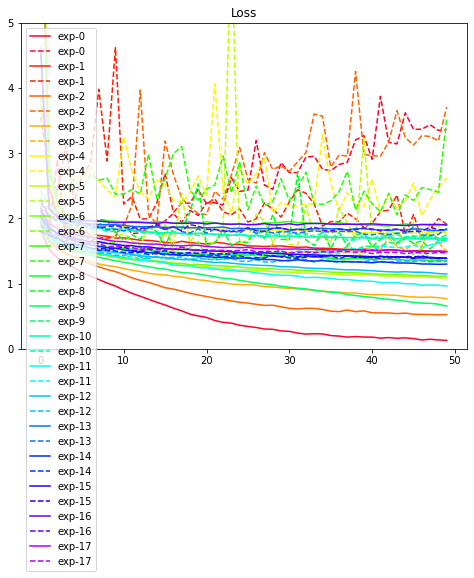

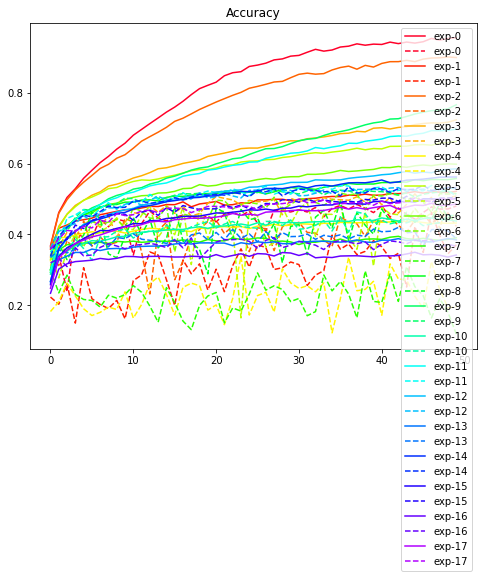

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()